# Week 2 Lab: Experiments with basic networks  and visualising the results


In [0]:
#@title
from __future__ import division, print_function, unicode_literals
from google.colab import files

# Common imports
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize']  = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "tensorflow"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    files.download(PROJECT_ROOT_DIR+'/images/'+CHAPTER_ID+'/'+fig_id + ".png") 

# Setting up your Data science project 

[cookiecutter datascience](https://drivendata.github.io/cookiecutter-data-science) is a git repo with some good advice on setting up your project. Read through this repo, and use it for projects in this course.

# Visualising simple networks

Let's try running some simple multi-layer perceptrons and see how they perform some basic regression and classification tasks. The goal here is to give you some insight into how a network represents the function or classifier, and what the impact of changing the parameters is. 


# Regression

We can start with a one dimensional regression task. A target system is $$ y = \sin(10\pi x\sin((x-0.5)^3))+\epsilon, $$where $\epsilon \sim \cal{N}(\mu, \sigma)$, and $\mu=0, \sigma=0.1$.


Text(0, 0.5, '$y$')

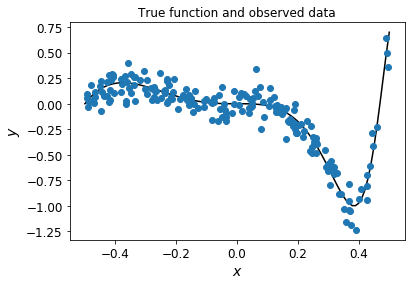

In [3]:
import math

def testfunc(x):
    #y = np.sin((4*math.pi*x**2))
    y = -np.sin((10*math.pi*(x+0.5)*np.sin((x)**3)))
    return y


xgrid = torch.t(torch.linspace(-0.5,0.5,100)).unsqueeze(1)
ytrue = testfunc(xgrid) # clean data from underlying function (not available for learning)

# now create some training data
N = 200         # number of noisy training observations made
noiseSigma = 0.1   # standard deviation of noise
noiseMean = 0.0    # mean of noise

x = torch.rand_like(torch.ones(N,1))-0.5
obserr = torch.randn(N,1)*noiseSigma + noiseMean
y = testfunc(x)+obserr

xtest  = torch.rand_like(torch.ones(N,1))-0.5
obserr = torch.randn(N,1)*noiseSigma + noiseMean
ytest  = testfunc(xtest)+obserr

fig = plt.figure()
plt.plot(xgrid, ytrue,'-k')
plt.plot(x,y,'o')
plt.title('True function and observed data')
plt.xlabel('$x$')
plt.ylabel('$y$')



> Indented block


.

In [7]:
!pip3 install torchvision

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Nhidden = 10
lamb = 0.001
lr = 0.01
epochs = 1000
batch_size = 64

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(1, Nhidden)  # See https://pytorch.org/docs/stable/nn.html#linear for documentation
        self.fc2 = nn.Linear(Nhidden, 1)  # Can you find out how the weights are initialised? Look in the source code https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/linear.py

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
 
net = Net()
print(net)

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=lamb)


for epoch in range(20000):  # loop over the dataset multiple times
    running_loss = 0.0

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(x)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if epoch % 2000 == 1999:    # print every 2000 mini-batches
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, 0 + 1, running_loss))
        running_loss = 0.0

print('Finished Training')



Net(
  (fc1): Linear(in_features=1, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)
[2000,     1] loss: 0.046
[4000,     1] loss: 0.043
[6000,     1] loss: 0.041
[8000,     1] loss: 0.040
[10000,     1] loss: 0.038
[12000,     1] loss: 0.036
[14000,     1] loss: 0.034
[16000,     1] loss: 0.031
[18000,     1] loss: 0.030
[20000,     1] loss: 0.028
Finished Training


Text(0.5, 1.0, 'Regression comparison')

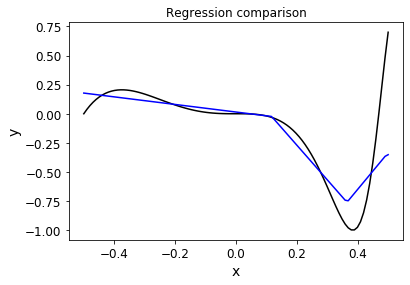

In [12]:
pred_y = net(x)
pred_ygrid =net(xgrid)

plt.figure()
plt.plot(xgrid, ytrue,'k-')
plt.plot(xgrid, pred_ygrid.detach().numpy(),'b-')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Regression comparison')

You can view the values of the layers as a list of numpy arrays using the [get_weights() ](https://keras.io/layers/about-keras-layers/) command in keras. Each layer can be accessed independently




In [13]:
print('First hidden layer weights', torch.t(net.fc1.weight)) # first hidden layer weights (transposed for ease of inspection)
print('First hidden layer biases', net.fc1.bias) # first hidden layer biases
print('Second layer weights',net.fc2.weight) # second layer
print('Second layer bias', net.fc2.bias) # second layer

First hidden layer weights tensor([[-0.1221, -0.1202, -0.0151, -2.2209,  0.0080,  0.0568, -1.0226, -0.9077,
         -1.6255, -1.3352]], grad_fn=<TBackward>)
First hidden layer biases Parameter containing:
tensor([-0.0881, -0.0808, -0.0526,  0.8098, -0.1309, -0.0045,  0.5056,  0.3311,
         0.1906,  0.6602], requires_grad=True)
Second layer weights Parameter containing:
tensor([[ 1.7168e-02,  2.9196e-02, -1.4373e-03,  2.3634e+00, -2.3912e-02,
          1.6321e-02, -1.1386e+00,  9.6633e-01, -1.6322e+00, -1.4852e+00]],
       requires_grad=True)
Second layer bias Parameter containing:
tensor([-0.3519], requires_grad=True)


Your task is to train a multilayer network with a single hidden layer to fit this function from the noisy data. 


1.   Experiment with the number of units in the model, and the impact of choice of activation function, number of training data, and noise levels on the data. 
2.   Plot a visualisation of the network output at `xgrid` inputs, and compare it with the `ytrue` results..
3.   Plot the responses of all the activation functions in the model and see how they change behaviour during learning and as the parameters change


# Classification task

Now we will try out some experiments with simple two-dimensional classification tasks. 


**Dataset 1**


181


Text(0, 0.5, '$x_2$')

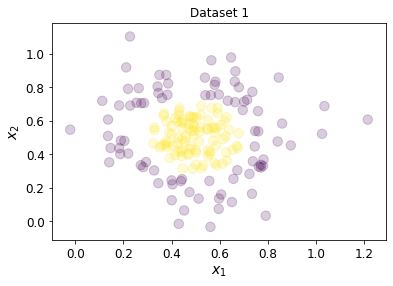

In [35]:
N = 200

xgrid = torch.arange(0,1.0,0.01)

X,Y = torch.meshgrid(xgrid, xgrid)
testgrid = torch.zeros((np.shape(xgrid)[0]**2,2))
testgrid[:,0] = X.flatten()
testgrid[:,1] = Y.flatten()


#try experimenting with different types of input distribution
#x = np.random.uniform(low = 0.0, high = 1.0, size= (N,2))
x = 0.2*torch.randn(N,2)+torch.tensor([0.5, 0.5])
y = ((torch.norm(x-0.5, dim=1) < 0.2)*1.0).type(torch.float)  # make the class be a circle in the centre of the scene.

# cut out a border around the classes to make the task a bit more realistic
ind_incl = (torch.norm(x-0.5, dim=1) > 0.25) | (torch.norm(x-0.5, dim=1) < 0.20)
x = x[ind_incl,:]
y = y[ind_incl]
N = y.shape[0]
y = y.reshape(N,1)
print(N)

Ntest = 1000
xtest = 0.2*torch.randn(Ntest,2)+torch.tensor([0.5, 0.5])
ytest = ((torch.norm(xtest-0.5, dim=1) < 0.2)*1.0).type(torch.float)

# cut out a border around the classes to make the task a bit more realistic
ind_incl = (torch.norm(xtest-0.5, dim=1) > 0.25) | (torch.norm(xtest-0.5, dim=1) < 0.20)
xtest = xtest[ind_incl,:]
ytest = ytest[ind_incl]

Ntest = ytest.shape[0]
ytest = ytest.reshape(Ntest,1)

plt.figure()
plt.scatter(x[:,0].numpy(),x[:,1].numpy(), alpha=0.2, s=90, cmap='viridis', c=y.view(-1))
plt.title('Dataset 1')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

In [51]:
Nhidden = 10
lamb=0.0001    # L2 weight decay term
lr = 0.01
epochs = 300
batch_size = 64


class Net2d(nn.Module):
    def __init__(self):
        super(Net2d, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, Nhidden) 
        self.fc2 = nn.Linear(Nhidden, Nhidden) 
        self.fc3 = nn.Linear(Nhidden, 1)
        self.fc4 = nn.Linear(Nhidden, Nhidden)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc4(x))
        x = torch.sigmoid(self.fc3(x))
        return x

net2d = Net2d()
print(net2d)



Net2d(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
  (fc4): Linear(in_features=10, out_features=10, bias=True)
)


In [52]:
criterion = nn.BCELoss()
optimizer = optim.SGD(net2d.parameters(), lr=lr, momentum=0.9, weight_decay=lamb) # Note that this is adding L2 regularisation with factor lamb to every parameter

for epoch in range(20000):  # loop over the dataset multiple times
    running_loss = 0.0

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net2d(x)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if epoch % 2000 == 1999:    # print every 2000 mini-batches
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, 0 + 1, running_loss))
        running_loss = 0.0



[2000,     1] loss: 0.011
[4000,     1] loss: 0.003
[6000,     1] loss: 0.002
[8000,     1] loss: 0.001
[10000,     1] loss: 0.001
[12000,     1] loss: 0.001
[14000,     1] loss: 0.001
[16000,     1] loss: 0.001
[18000,     1] loss: 0.001
[20000,     1] loss: 0.001


Btw, an alternative, simple way to create basic networks is with the `nn.Sequential` container

Final training set loss  0.0007515422184951603
Test loss  0.014096100814640522
Percentage correct  99


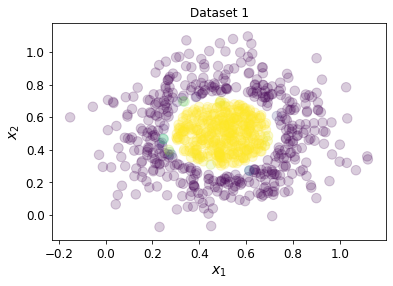

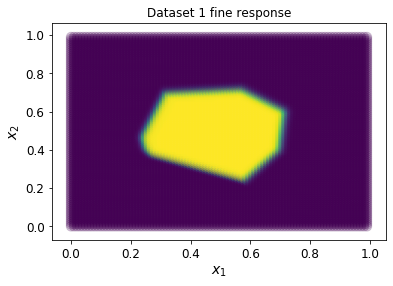

In [53]:
pred_test = net2d(xtest)
plt.figure()
plt.scatter(xtest[:,0],xtest[:,1], alpha=0.2, s=90, cmap='viridis', c=pred_test[:,0].detach().numpy())
plt.title('Dataset 1')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

pred_testgrid = net2d(testgrid)
plt.figure()
plt.scatter(testgrid[:,0],testgrid[:,1], alpha=0.2, s=90, cmap='viridis', c=pred_testgrid[:,0].detach().numpy())
plt.title('Dataset 1 fine response')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

print('Final training set loss ', criterion(outputs, y).item())
test_loss = criterion(pred_test, ytest)
print('Test loss ', test_loss.item())
classification = torch.round(pred_test)
percentage = 100*sum(ytest.type(torch.int) == classification.type(torch.int))/Ntest
print('Percentage correct ', percentage.item())

In [43]:
net2d = nn.Sequential(nn.Linear(2,Nhidden),
                      nn.Sigmoid(),
                      nn.Linear(Nhidden, 1),
                      nn.Sigmoid())
net2d

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=10, out_features=1, bias=True)
  (3): Sigmoid()
)

Try repeating these experiments with the following variations:
- Try with 200, 500, 2000 training points. How does that change the response of the function?
  None of this training points can give reasonable boundary.
- try with Sigmoids in the hidden layer rather than ReLUs. 
    - How does that change the shape of the decision boundary? Why do you think this is?
    It break the boundary. Sigmoid needs more iteration to fit the data.
    - How does it change the speed of error reduction?
    Reduction becomes really slow.
- try changing the number of hidden units. What changes?
    - Do you see as many 'edges' on the decision boundary when using ReLUs as units? Why do you think this is?
- try with 1,2,3 hidden layers. 
- what happens if you increase `lamb`?
    - what happens to lowest error achieved in training? 
    - what happens to the shape of the decision boundary?
    - what happens to the speed of learning?
- during the above you may find that some configurations take a lot longer to reduce the error than others.



Try changing the loss function from Binary Cross-Entropy (`BCEloss`) to `MSEloss`. How does that affect performance? How does it affect perfomance in `mse`? Your choice of cost function is linked to the output type, as shown in the table below:
![output/cost function table](https://docs.google.com/uc?export=download&id=1Z2C-NJh35shzvtMlvEtDpyQgGM10bvew)


Try increasing the number of training data, and changing the network architecture.


Text(0, 0.5, '$x_2$')

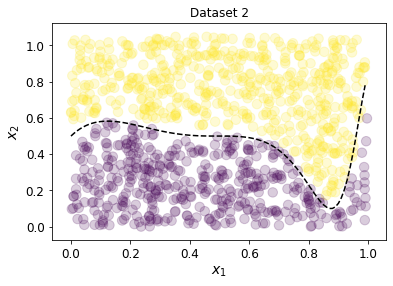

In [54]:
N = 1000

xgrid1 = torch.arange(0,1.0,0.01)

#try experimenting with different types of input distribution
data_dist = 1 # 1 - uniform 0.5-0.5, 2 - normally distributed

if data_dist == 1:
   x = torch.rand(N,2)
else:
   x = 0.15*torch.randn(N,2)+torch.tensor([0.5, 0.5])
ind_pos = (0.5+0.4*testfunc(x[:,0]-0.5)<x[:,1])
y = (ind_pos*1.0).type(torch.float)  # lets create a classification line based on old regression function
N = y.shape[0]
y = y.reshape(N,1)
x[ind_pos,1] = x[ind_pos,1]+0.05 # create a gap between classes.


if data_dist == 1:
  xtest = torch.rand(N,2)
else:
  xtest = 0.15*torch.randn(N,2)+torch.tensor([0.5, 0.5])
ind_post = (0.5+0.4*testfunc(xtest[:,0]-0.5)<xtest[:,1])
ytest = (ind_post*1.0).type(torch.float)  # let's create a classification line based on old regression function
Ntest = ytest.shape[0]
ytest = ytest.reshape(Ntest,1)
xtest[ind_post,1] = xtest[ind_post,1]+0.05 # create a gap between classes.


plt.figure()
plt.scatter(x[:,0],x[:,1], alpha=0.2, s=90, cmap='viridis', c=y.view(-1))
plt.plot(xgrid1, 0.5+0.4*ytrue,'--k')  # show the 'true' classification line for this problem
plt.title('Dataset 2')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')



In [0]:


Nhidden = 20
lamb=0.001
lr = 0.01
epochs = 1000
batch_size = 64

net2d = nn.Sequential(nn.Linear(2,Nhidden),
                      nn.ReLU(),
                      nn.Linear(Nhidden, Nhidden),
                      nn.ReLU(),
                      nn.Linear(Nhidden, 1),
                      nn.Sigmoid())
#reuse net2d


In [56]:
criterion = nn.BCELoss()
optimizer = optim.SGD(net2d.parameters(), lr=lr, momentum=0.9, weight_decay=lamb) # Note that this is adding L2 regularisation with factor lamb to every parameter

for epoch in range(20000):  # loop over the dataset multiple times
    running_loss = 0.0

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net2d(x)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if epoch % 2000 == 1999:    # print every 2000 mini-batches
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, 0 + 1, running_loss))
        running_loss = 0.0

[2000,     1] loss: 0.090
[4000,     1] loss: 0.071
[6000,     1] loss: 0.062
[8000,     1] loss: 0.057
[10000,     1] loss: 0.053
[12000,     1] loss: 0.049
[14000,     1] loss: 0.046
[16000,     1] loss: 0.044
[18000,     1] loss: 0.042
[20000,     1] loss: 0.040


Final training set loss  0.04019737243652344
Test loss  0.0469931922852993
Percentage correct  98.69999694824219


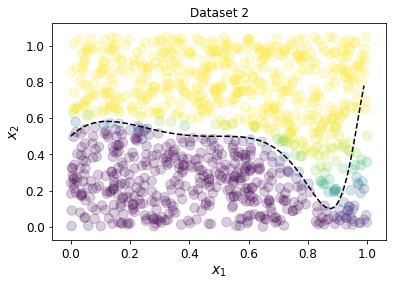

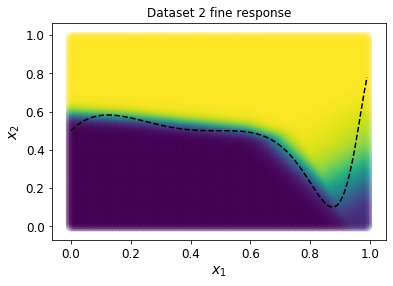

In [57]:
pred_test = net2d(xtest)
plt.figure()
plt.scatter(xtest[:,0],xtest[:,1], alpha=0.2, s=90, cmap='viridis', c=pred_test[:,0].detach().numpy())
plt.plot(xgrid1, 0.5+0.4*ytrue,'--k')  # show the 'true' classification line for dataset2 problem
plt.title('Dataset 2')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

pred_testgrid = net2d(testgrid)
plt.figure()
plt.scatter(testgrid[:,0],testgrid[:,1], alpha=0.2, s=90, cmap='viridis', c=pred_testgrid[:,0].detach().numpy())
plt.plot(xgrid1, 0.5+0.4*ytrue,'--k')  # show the 'true' classification line for this problem
plt.title('Dataset 2 fine response')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

print('Final training set loss ', criterion(outputs, y).item())
test_loss = criterion(pred_test, ytest)
print('Test loss ', test_loss.item())
classification = torch.round(pred_test)
percentage = 100.0*torch.sum(ytest.type(torch.int) == classification.type(torch.int))/Ntest
print('Percentage correct ', percentage.item())

Try changing the distribution of the training data (e.g. make it normally distributed) but keeping the same classification boundary. How does that change the resulting classification boundary?

# Homework

Work your way through the Colab file and experiment with the network architectures.
